### Dynamic Time Warping
https://en.wikipedia.org/wiki/Dynamic_time_warping

In time series analysis, dynamic time warping (DTW) is an algorithm for measuring similarity between two temporal sequences, which may vary in speed.
We will use it to gain insight on QQQ which follows the nasdaq index and Bitcoin Futures (BTC) 
We will test in various forms:
1) Only business days (since BTC trades daily and QQQ on business days)
2) Only business days, and apply Moving Average (MA) before DTW (The idea is to smooth the signal and remove potential noise)
3) Only business days, and apply Exponential Moving Average (EMA) before DTW (a different way of removing noise)
4) Business days for QQQ and daily data for BTC. Also test for smoothing/de-noising with MA and EMA
5) Test for returns (Correlation vs. DTW: A low correlation but low DTW distance suggests non-linear similarities - e.g., lagged movements).

Let's evaluate the lag values that represent daily intervals and see if there is a pattern for different time periods.
* 2023-01-01 ~ 2024-12-31: Largest peak is 130. Second largest is 0. Price DTW distance = Avg of 12.6 without outliers, Return DTW distance = 11.1
* 2022-01-01 ~ 2024-12-31: Largest peak is 0. Second largest is 130. Price DTW distance = Avg of 16 without outliers, Return DTW distance = 16
* 2020-01-01 ~ 2022-12-31: Largest peak is 0. Second largest is 90 and -90. Price DTW distance = Avg of 53 without outliers, Return DTW distance = 19.6
* 2021-01-01 ~ 2023-12-31: Largest peak is -10. Second largest is -30. Price DTW distance = Avg of 69 without outliers, Return DTW distance = 18.2

The Avg Price DTW distance contains the average distance for prices, MA and EMA. All three have similar values, with EMA providing the shortest distance for all periods. What seems to stay consistent over different time periods is the Return DTW distance. So we test for another ticker 'DOW' and evaluate the results. What we see is that DOW returns have arround the same distance that the QQQ had, while for normalized prices the distance is significantly larger. Therefore using FastDTW for returns dosent seem to be the best tactic!
The lag peaks change over different time periods. This could indicate that lags are random and not statistical significant, or it could be because of a market regime change, which we have not considered. Therefore we could test what the lags are for different time periods, with similar regimes.
The lag peaks are the same for prices and returns.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

After testing for 'QQQ' change the ticker to 'DOW' and evaluate the results!!!

In [2]:
start_date = "2022-01-01"
end_date = "2024-12-31"

qqq = yf.download("QQQ", start=start_date, end=end_date, interval="1d")['Close']
btc_f = yf.download("BTC=F", start=start_date, end=end_date, interval="1d")['Close']
print(len(qqq), len(btc_f))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

752 753


In [3]:
# Combine into a single DataFrame, aligning by date while keeping prices
aligned_df = pd.concat([qqq, btc_f], axis=1, join='inner')

# Rename columns for clarity
aligned_df.columns = ['QQQ_Price', 'BTC_F_Price']

# Print the first few rows
aligned_df.head()

,QQQ_Price,BTC_F_Price
Date,,
2022-01-03,393.665924,45865.0
2022-01-04,388.559875,46305.0
2022-01-05,376.622925,43830.0
2022-01-06,376.358246,43215.0
2022-01-07,372.281281,41870.0


In [4]:
aligned_df.corr()

,QQQ_Price,BTC_F_Price
QQQ_Price,1.000000,0.919211
BTC_F_Price,0.919211,1.000000


In [5]:
x = np.array(aligned_df['QQQ_Price']).reshape(-1, 1)
y = np.array(aligned_df['BTC_F_Price']).reshape(-1, 1)

distance, path = fastdtw(x, y, dist=euclidean)

print("DTW distance:", distance)

DTW distance: 30615109.178863525


In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_s = scaler.fit_transform(x)  # Normalize QQQ
y_s = scaler.fit_transform(y)  # Normalize BTC_F

distance, path = fastdtw(x_s, y_s, dist=euclidean)

print("DTW distance:", distance)

DTW distance: 23.52081507576616


In [7]:
len(path)

1251

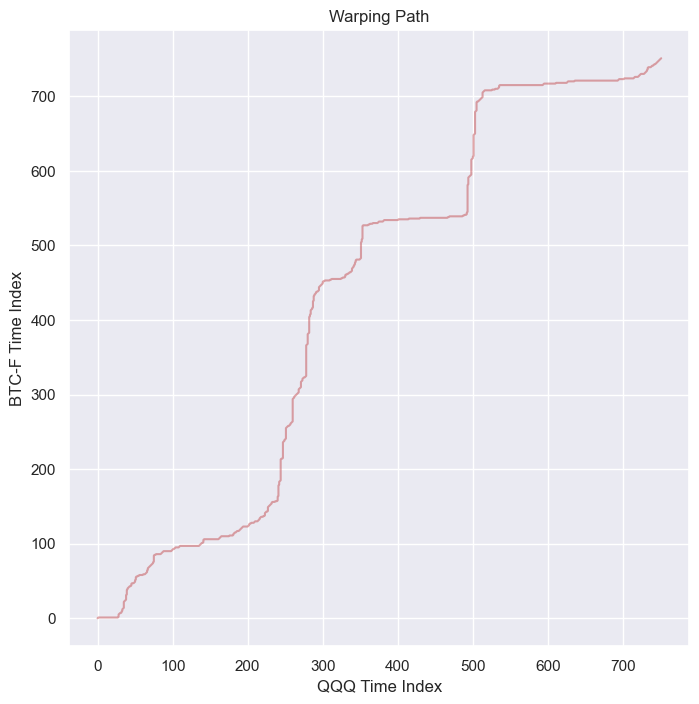

In [8]:
plt.figure(figsize=(8,8))
plt.plot([i for i, _ in path], [j for _, j in path], 'r-', alpha=0.5)
plt.title("Warping Path")
plt.xlabel("QQQ Time Index")
plt.ylabel("BTC-F Time Index")
plt.show()

In [9]:
lags = [j - i for (i, j) in path]  
np.median(lags)

66.0

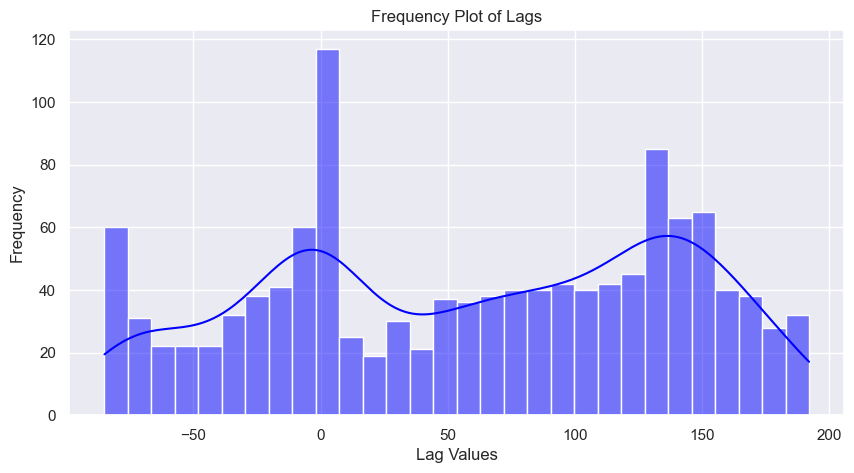

In [10]:
plt.figure(figsize=(10, 5))
sns.histplot(lags, bins=30, kde=True, color='blue')

# Labels and title
plt.xlabel("Lag Values")
plt.ylabel("Frequency")
plt.title("Frequency Plot of Lags")
plt.grid(True)

# Show plot
plt.show()

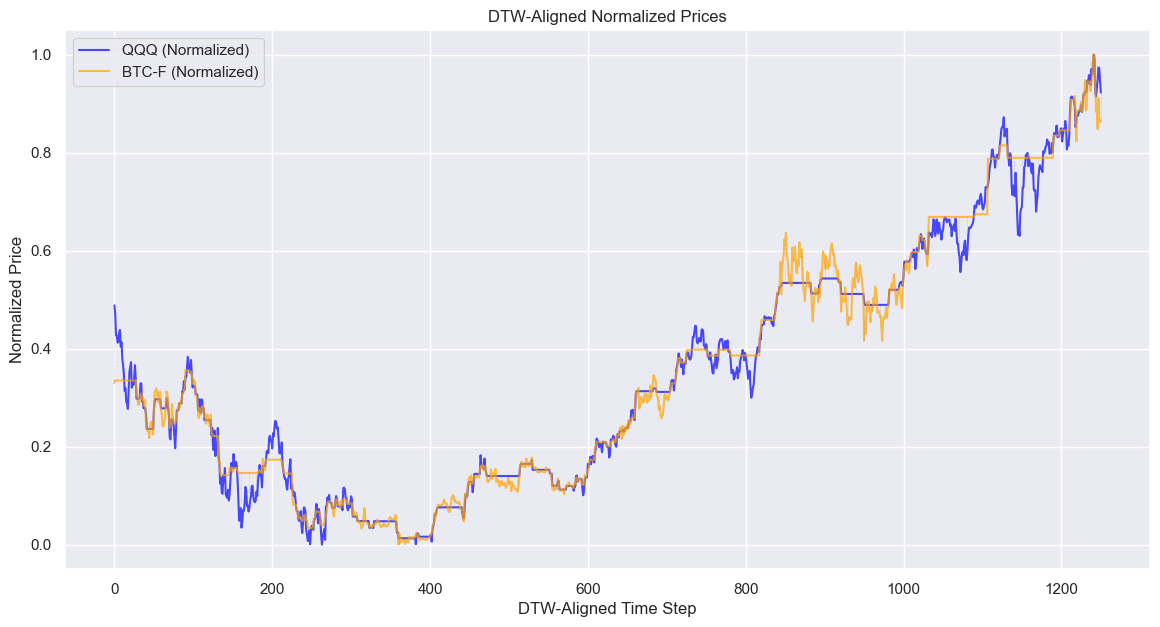

In [11]:
# Extract normalized prices from x and y using the DTW path
qqq_aligned = [x_s[i][0] for (i, j) in path]  # Normalized QQQ prices
btc_aligned = [y_s[j][0] for (i, j) in path]  # Normalized BTC-F prices
aligned_steps = np.arange(len(path))        # DTW-aligned time steps

# Plot both normalized series
plt.figure(figsize=(14, 7))
plt.plot(aligned_steps, qqq_aligned, label='QQQ (Normalized)', color='blue', alpha=0.7)
plt.plot(aligned_steps, btc_aligned, label='BTC-F (Normalized)', color='orange', alpha=0.7)

# Draw connecting lines every 10 steps to reduce clutter
for step in aligned_steps[::10]:
    plt.plot(
        [step, step], 
        [qqq_aligned[step], btc_aligned[step]], 
        color='gray', 
        linestyle='--', 
        linewidth=0.5, 
        alpha=0.3
    )

plt.title("DTW-Aligned Normalized Prices")
plt.xlabel("DTW-Aligned Time Step")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

### Moving Average

DTW distance (MA): 17.040440134969238


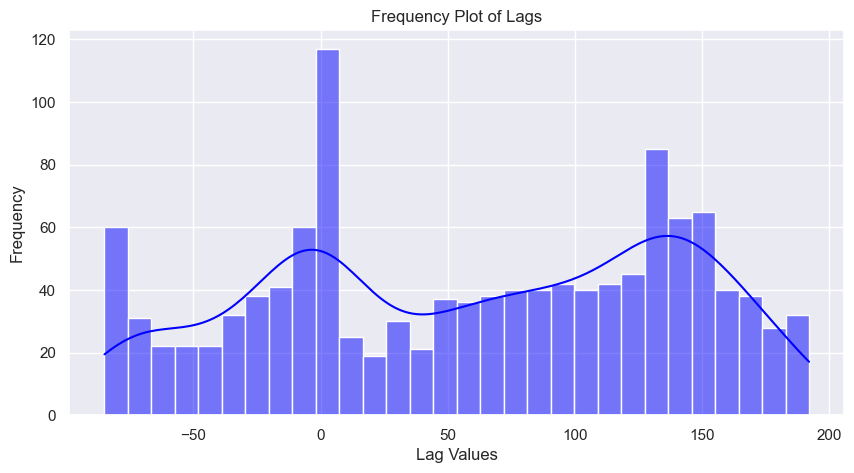

In [12]:
window = 20  # Adjust the window size as needed

# Compute moving averages
aligned_df['QQQ_MA'] = aligned_df['QQQ_Price'].rolling(window=window).mean()
aligned_df['BTC_F_MA'] = aligned_df['BTC_F_Price'].rolling(window=window).mean()

# Drop NaN values (from rolling window)
ma_df = aligned_df.dropna().copy()

scaler = MinMaxScaler()
qqq_ma = scaler.fit_transform(ma_df['QQQ_MA'].values.reshape(-1, 1))
btc_ma = scaler.fit_transform(ma_df['BTC_F_MA'].values.reshape(-1, 1))

distance_ma, path_ma = fastdtw(qqq_ma, btc_ma, dist=euclidean)
print(f"DTW distance (MA): {distance_ma}")

lags = [j - i for (i, j) in path]  

plt.figure(figsize=(10, 5))
sns.histplot(lags, bins=30, kde=True, color='blue')

# Labels and title
plt.xlabel("Lag Values")
plt.ylabel("Frequency")
plt.title("Frequency Plot of Lags")
plt.grid(True)

# Show plot
plt.show()

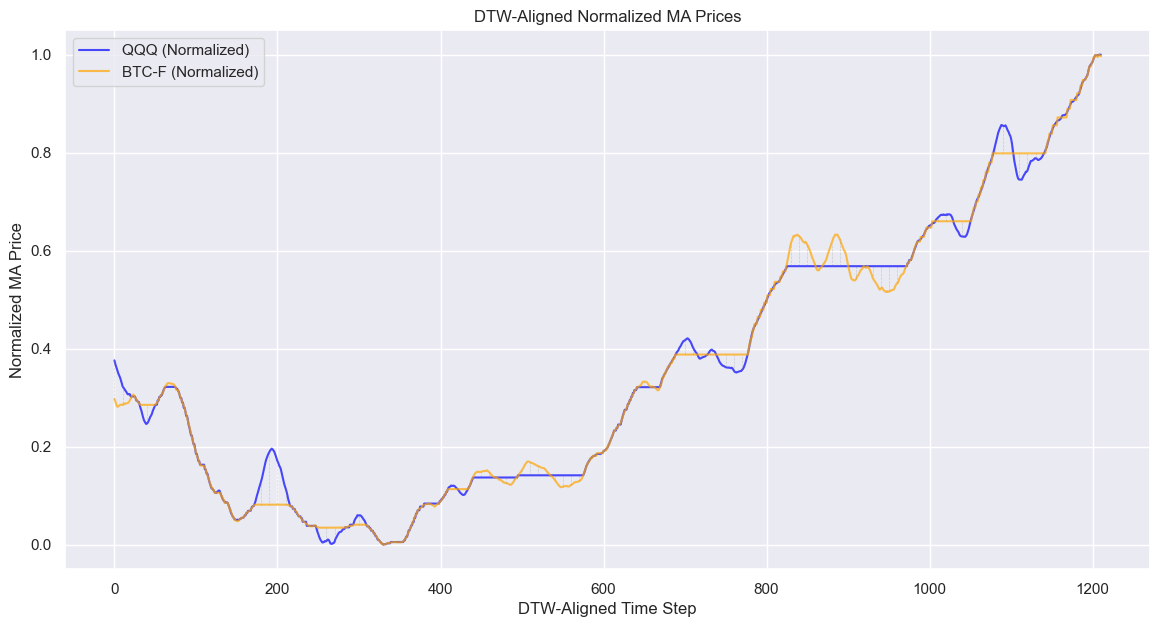

In [13]:
# Extract normalized prices from x and y using the DTW path
qqq_aligned = [qqq_ma[i][0] for (i, j) in path_ma]  # Normalized QQQ prices
btc_aligned = [btc_ma[j][0] for (i, j) in path_ma]  # Normalized BTC-F prices
aligned_steps = np.arange(len(path_ma))        # DTW-aligned time steps

# Plot both normalized series
plt.figure(figsize=(14, 7))
plt.plot(aligned_steps, qqq_aligned, label='QQQ (Normalized)', color='blue', alpha=0.7)
plt.plot(aligned_steps, btc_aligned, label='BTC-F (Normalized)', color='orange', alpha=0.7)

# Draw connecting lines every 10 steps to reduce clutter
for step in aligned_steps[::10]:
    plt.plot(
        [step, step], 
        [qqq_aligned[step], btc_aligned[step]], 
        color='gray', 
        linestyle='--', 
        linewidth=0.5, 
        alpha=0.3
    )

plt.title("DTW-Aligned Normalized MA Prices")
plt.xlabel("DTW-Aligned Time Step")
plt.ylabel("Normalized MA Price")
plt.legend()
plt.show()

### Exponential Moving Average

EMA DTW distance: 15.29


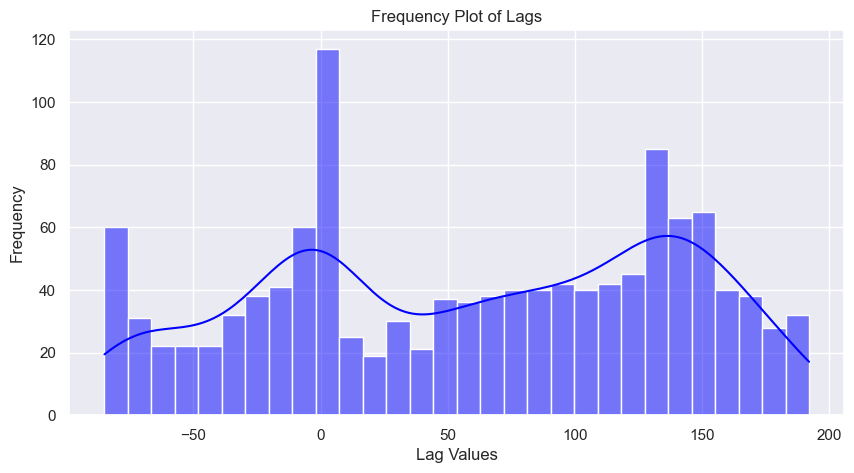

In [14]:
# Calculate EMA with a 20-day span (adjust as needed)
ema_span = 20

# Compute EMAs
aligned_df['QQQ_EMA'] = aligned_df['QQQ_Price'].ewm(span=ema_span, adjust=False).mean()
aligned_df['BTC_F_EMA'] = aligned_df['BTC_F_Price'].ewm(span=ema_span, adjust=False).mean()

ema_df = aligned_df.dropna().copy()

scaler = MinMaxScaler()
qqq_ema = scaler.fit_transform(ema_df['QQQ_EMA'].values.reshape(-1, 1))
btc_ema = scaler.fit_transform(ema_df['BTC_F_EMA'].values.reshape(-1, 1))

distance_ema, path_ema = fastdtw(qqq_ema, btc_ema, dist=euclidean)
print(f"EMA DTW distance: {distance_ema:.2f}")

lags = [j - i for (i, j) in path]  

plt.figure(figsize=(10, 5))
sns.histplot(lags, bins=30, kde=True, color='blue')

# Labels and title
plt.xlabel("Lag Values")
plt.ylabel("Frequency")
plt.title("Frequency Plot of Lags")
plt.grid(True)

# Show plot
plt.show()

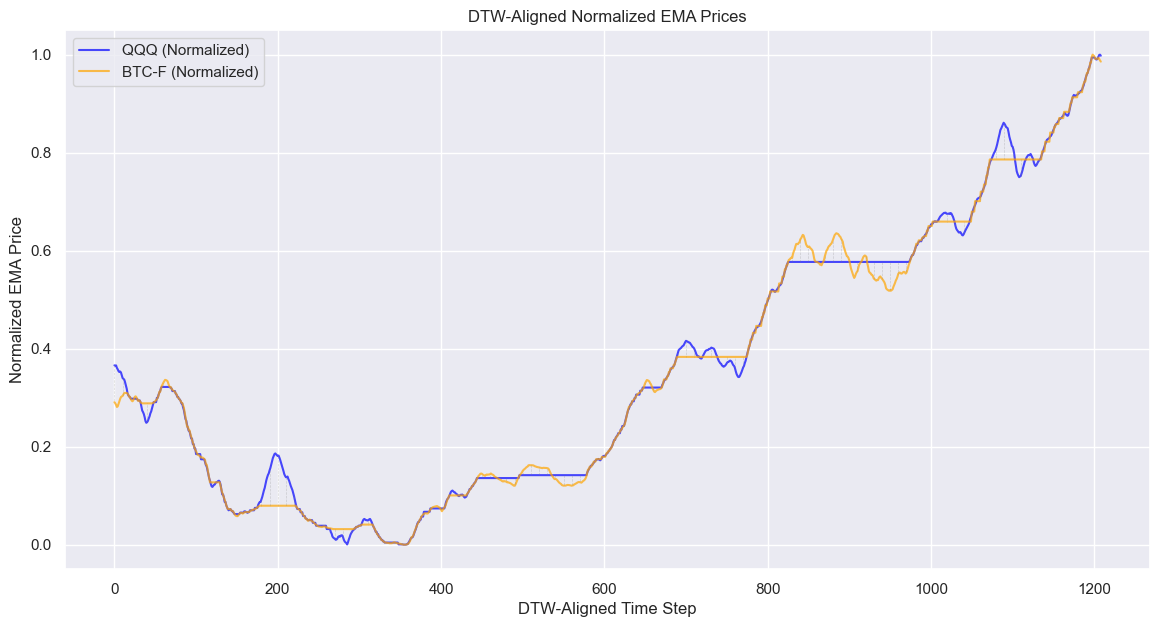

In [15]:
# Extract normalized prices from x and y using the DTW path
qqq_aligned = [qqq_ema[i][0] for (i, j) in path_ema]  # Normalized QQQ prices
btc_aligned = [btc_ema[j][0] for (i, j) in path_ema]  # Normalized BTC-F prices
aligned_steps = np.arange(len(path_ema))        # DTW-aligned time steps

# Plot both normalized series
plt.figure(figsize=(14, 7))
plt.plot(aligned_steps, qqq_aligned, label='QQQ (Normalized)', color='blue', alpha=0.7)
plt.plot(aligned_steps, btc_aligned, label='BTC-F (Normalized)', color='orange', alpha=0.7)

# Draw connecting lines every 10 steps to reduce clutter
for step in aligned_steps[::10]:
    plt.plot(
        [step, step], 
        [qqq_aligned[step], btc_aligned[step]], 
        color='gray', 
        linestyle='--', 
        linewidth=0.5, 
        alpha=0.3
    )

plt.title("DTW-Aligned Normalized EMA Prices")
plt.xlabel("DTW-Aligned Time Step")
plt.ylabel("Normalized EMA Price")
plt.legend()
plt.show()

### Try it out for returns

In [16]:
x_r = (x[1:] / x[:-1]) -1 
y_r = (y[1:] / y[:-1]) -1

distance, path = fastdtw(x_r, y_r, dist=euclidean)

print("DTW distance:", distance)

DTW distance: 16.099275978645494


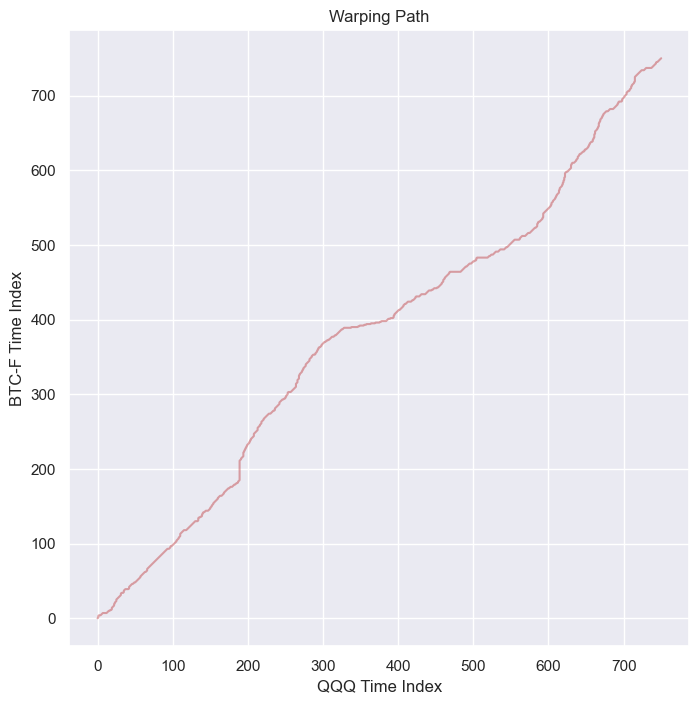

In [17]:
plt.figure(figsize=(8,8))
plt.plot([i for i, _ in path], [j for _, j in path], 'r-', alpha=0.5)
plt.title("Warping Path")
plt.xlabel("QQQ Time Index")
plt.ylabel("BTC-F Time Index")
plt.show()

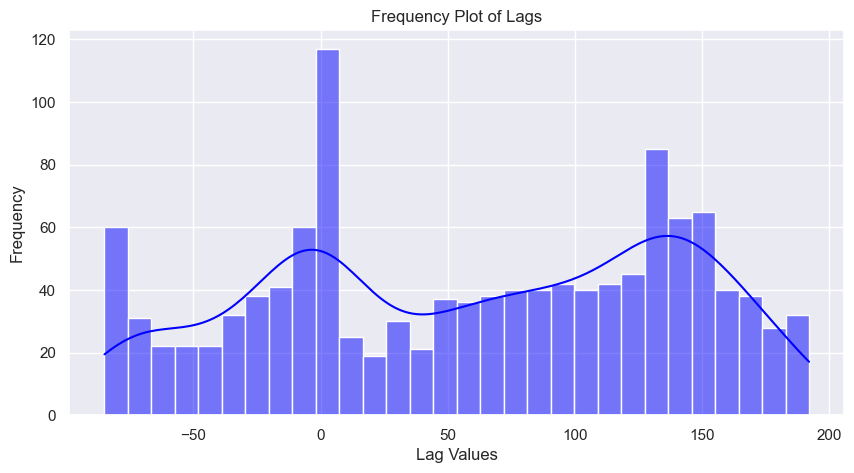

In [18]:
plt.figure(figsize=(10, 5))
sns.histplot(lags, bins=30, kde=True, color='blue')

# Labels and title
plt.xlabel("Lag Values")
plt.ylabel("Frequency")
plt.title("Frequency Plot of Lags")
plt.grid(True)

# Show plot
plt.show()

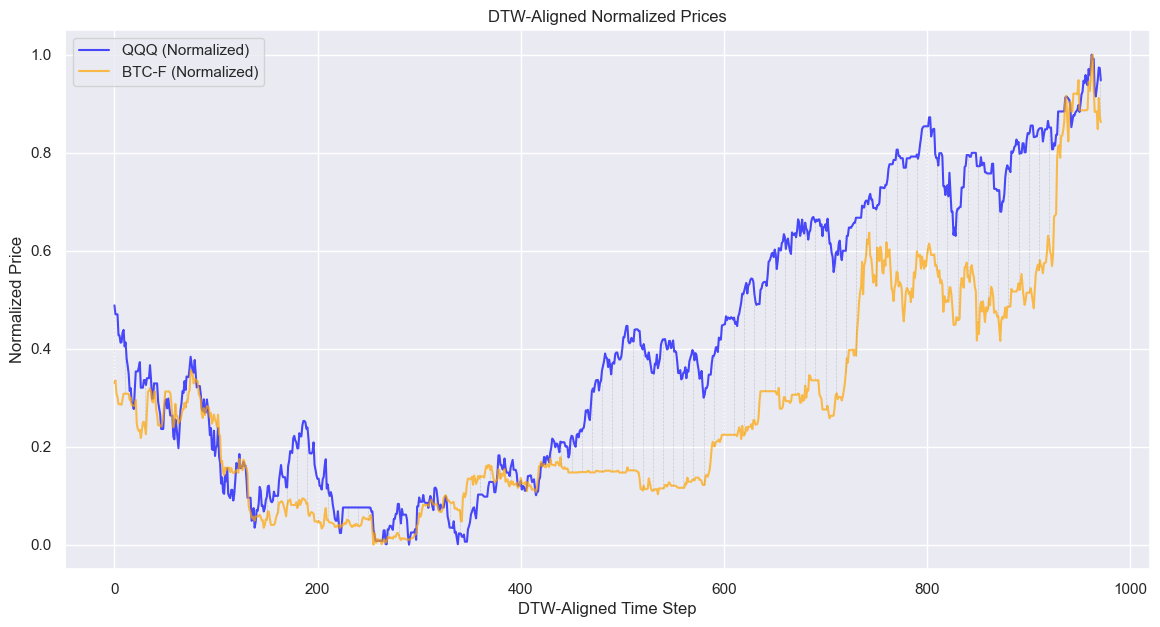

In [19]:
# Extract normalized prices from x and y using the DTW path
qqq_aligned = [x_s[i][0] for (i, j) in path]  # Normalized QQQ prices
btc_aligned = [y_s[j][0] for (i, j) in path]  # Normalized BTC-F prices
aligned_steps = np.arange(len(path))        # DTW-aligned time steps

# Plot both normalized series
plt.figure(figsize=(14, 7))
plt.plot(aligned_steps, qqq_aligned, label='QQQ (Normalized)', color='blue', alpha=0.7)
plt.plot(aligned_steps, btc_aligned, label='BTC-F (Normalized)', color='orange', alpha=0.7)

# Draw connecting lines every 10 steps to reduce clutter
for step in aligned_steps[::10]:
    plt.plot(
        [step, step], 
        [qqq_aligned[step], btc_aligned[step]], 
        color='gray', 
        linestyle='--', 
        linewidth=0.5, 
        alpha=0.3
    )

plt.title("DTW-Aligned Normalized Prices")
plt.xlabel("DTW-Aligned Time Step")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

In [20]:
x_rf = x_r.flatten()
y_rf = y_r.flatten()
np.corrcoef(x_rf, y_rf)[0, 1]

0.4383106894217689

### Conclusion
A diagonal DTW path for returns suggests minimal time warping (i.e., near 1:1 alignment). This implies returns are aligned without significant lags.

However, low zero-lag correlation (Pearson) with a diagonal DTW path is contradictory. Normally:

Diagonal DTW path ≈ High linear correlation (if returns are aligned).

Low Pearson correlation suggests either:

1) Non-linear relationships (DTW captures these better than Pearson).

2) Outliers distorting Pearson correlation (DTW is robust to outliers).

#### Checking for outliers

In [21]:
# IQR Filtering & Pearson Correlation
data = np.column_stack((x_rf, y_rf))

# Calculate IQR for each column (asset)
Q1 = np.percentile(data, 25, axis=0)
Q3 = np.percentile(data, 75, axis=0)
IQR = Q3 - Q1

# Define outlier bounds [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Create a boolean mask for non-outliers (both columns must be within bounds)
mask = (data >= lower) & (data <= upper)
mask_combined = mask.all(axis=1)  # True only if both assets are within bounds

# Filter data
filtered_data = data[mask_combined]

# Compute Pearson correlation on cleaned data
pearson_corr = np.corrcoef(filtered_data.T)[0, 1]  # T is transpose
print(f"Pearson Correlation (IQR-filtered): {pearson_corr:.3f}")

Pearson Correlation (IQR-filtered): 0.356


In [22]:
# Compute ranks for Spearman (handle ties by averaging)
ranks = data.argsort(axis=0).argsort(axis=0) + 1  # Assign ranks
spearman_corr = np.corrcoef(ranks.T)[0, 1]
print(f"Spearman Correlation: {spearman_corr:.3f}")

Spearman Correlation: 0.407


In [23]:
from scipy.stats import kendalltau

# Compute Kendall's Tau (SciPy handles ties automatically)
kendall_corr, _ = kendalltau(data[:, 0], data[:, 1])
print(f"Kendall's Tau: {kendall_corr:.3f}")

Kendall's Tau: 0.279


#### Checking for non linear relationships

In [24]:
# takes some time...
from dcor import distance_correlation
dcor = distance_correlation(x_rf, y_rf)
print(f"Distance Correlation: {dcor:.3f}")

Distance Correlation: 0.388


In [25]:
from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(x_rf.reshape(-1, 1), y_rf)
print(f"Mutual Information: {mi[0]:.3f}")

Mutual Information: 0.092


In [26]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Fit quadratic model
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(x_rf.reshape(-1, 1))
model = LinearRegression().fit(X_poly, y_rf)
r2 = r2_score(y_rf, model.predict(X_poly))
print(f"R² (Quadratic Model): {r2:.3f}")

R² (Quadratic Model): 0.193


Pearson (0.308) and Spearman (0.355) correlations indicate a low to moderate linear/monotonic relationship.

Distance Correlation (0.338) confirms a moderate non-linear relationship, but it is not strong enough to drive actionable insights.

Mutual Information (0.088) and Quadratic R² (0.138) suggest the relationship is noisy and lacks significant predictive power.

The diagonal DTW path indicates the two assets move in a time-synchronized manner (minimal lag), but this alignment does not translate to meaningful correlation in magnitude or direction.

This could indicate shared exposure to macroeconomic factors (e.g., interest rates) without direct causal linkage.